In [1]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import mshr
import ufl
import itertools

### Mesh, periodic boundary

volume =  1.0


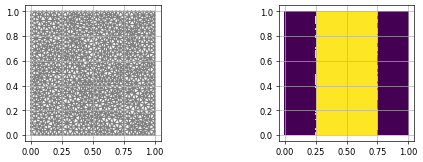

In [2]:
# Create the mesh for laminate microstructure
vertices = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])

square = mshr.Rectangle(Point(0, 0), Point(1, 1))
strip = mshr.Rectangle(Point(0.25, -1), Point(0.75, 1))

square.set_subdomain(1, strip)
mesh = mshr.generate_mesh(square, 24)
subdomain_marker = MeshFunction(
    'size_t', mesh, mesh.topology().dim(), mesh.domains())

# Compute volume of RVE
a = np.zeros((2, 2))      # direction vectors that define RVE.
a[0,:] = vertices[1,:] - vertices[0,:]
a[1,:] = vertices[3,:] - vertices[0,:]
vol = np.linalg.det(a); print("volume = ", vol)

# Plot the mesh and subdomains
plt.figure(figsize=(10, 3), dpi=60)
plt.subplot(1,2,1); plot(mesh); plt.grid()
plt.subplot(1,2,2); plot(subdomain_marker); plt.grid()

In [3]:
# class used to define the periodic boundary map
class PeriodicBoundary(SubDomain):
    # Constructor
    def __init__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        super().__init__()
        self.TOL = TOL
        self.vertices = vertices
        # vectors generating periodicity
        self.a = np.array([vertices[1,:] - vertices[0,:],
                          vertices[3,:] - vertices[0,:]])
        
        # vectors normal to vectors a[0,:] and a[1,:]
        self.n = np.array([[ -self.a[0,1], self.a[0,0] ], 
                          [ -self.a[1,1], self.a[1,0] ]])
        
    def inside(self, x, on_boundary):
        # return True if x is on the left or bottom boundaries
        # AND NOT on one of the bottom-right or top-left vertices
        top_left = np.allclose(x, self.vertices[3,:])
        bottom_right = np.allclose(x, self.vertices[1,:])
        x_vector = x - self.vertices[0,:]
        bottom = np.abs(np.dot(self.n[0,:], x_vector)) < self.TOL
        left = np.abs(np.dot(self.n[1,:], x_vector)) < self.TOL
            
        return (left or bottom) and \
            (not (top_left or bottom_right)) and on_boundary
    
    # Map the right to the left, the top to the bottom boundaries
    def map(self, x, y):
        # top right node
        if np.allclose(x, self.vertices[2,:]):
            y[0] = x[0] - (self.a[0, 0] + self.a[1,0])
            y[1] = x[1] - (self.a[0, 1] + self.a[1,1])
        # right boundary
        elif np.abs(np.dot(self.n[1,:], 
                           x - self.vertices[1,:])) < self.TOL:
            y[0] = x[0] - self.a[0,0]
            y[1] = x[1] - self.a[0,1]
        # top boundary
        else:  
            y[0] = x[0] - self.a[1,0]
            y[1] = x[1] - self.a[1,1]

# Create an instance of periodic boundary condition
pbc = PeriodicBoundary(vertices)

In [4]:
# Elastic parameters for two different phases
E = np.array([1.0, 5.0])
nu = np.array([0.33, 0.4])
mu_ = E/(2*(1 + nu))
beta_ = 2*nu/(1 - 2*nu)

class ParameterFunc(UserExpression):
    def __init__(self, subdomain_marker, para_values, **kwargs):
        super().__init__(**kwargs)
        self.para_values = para_values
        self.subdomain_marker = subdomain_marker
            
    def eval_cell(self, value, x, ufl_cell):
        if self.subdomain_marker[ufl_cell.index] == 0:
            value[0] = self.para_values[0]
        else:
            value[0] = self.para_values[1]
    
    def value_shape(self):
        return ()
    
mu_func = ParameterFunc(subdomain_marker, mu_, degree=2)
beta_func = ParameterFunc(subdomain_marker, beta_, degree=2)

### Solution using FEniCS nonlinear solver

In [5]:
V = VectorFunctionSpace(mesh, "CG", degree=2,
                        constrained_domain=pbc)
du = TrialFunction(V)
v = TestFunction(V)
u_fluc = Function(V)
# Macroscopic deformation gradient
theta = 0
R_Macro_arr = np.array([[np.cos(theta), -np.sin(theta)], 
                        [np.sin(theta), np.cos(theta)]])
U_Macro_arr = np.array([[1.15, 0.05], 
                      [0.05, 0.9]])
F_Macro_arr = np.dot(R_Macro_arr, U_Macro_arr)
F_Macro = Constant(F_Macro_arr)

# Kinematics
d = mesh.geometric_dimension()  # spatial dimension
F = F_Macro + grad(u_fluc)
C = F.T * F                     # right cauchy-green tensor
J = det(F)
Ic = tr(C)

# define the volume integral element
dx = Measure('dx', subdomain_data=subdomain_marker)

# Stored strain energy densities for two different materials.
# psi = 0.5 * mu_func * (Ic - d) \
#    + mu_func/beta_func * (J**(-beta_func)- 1)

# Pi = psi * dx
# Residual = derivative(Pi, u_fluc, v)

# First Piola-Kirchhoff stress
P = mu_func * F - mu_func * (J**(-beta_func)) * (inv(F).T)

Residual = inner(grad(v), P) * dx
Hessian = derivative(Residual, u_fluc, du)

solve(Residual == 0, u_fluc, [], J = Hessian)

In [6]:
F_func = grad(u_fluc) + F_Macro

F_func_val = project(F_func, 
                     TensorFunctionSpace(mesh, "DG", 2))

print(F_func_val(0.1, 0.5))
print(F_func_val(0.5, 0.5))

[1.20997039 0.05       0.12094367 0.9       ]
[ 1.09002961  0.05       -0.02094367  0.9       ]


## Macroscopic tangent stiffness

To compute the macroscopic tangent stiffness $\overline{\mathbb{C}}$, we may use finite difference formulas. To do so, we need to give each component of the macroscopic deformation gradient $\overline{\mathbf{F}}$ a small perturbation $\epsilon$ and then compute the corresponding macroscopic stress $\overline{\mathbf{P}}$. The macroscopic tangent stiffness is then approximated according to
\begin{equation}
\overline{C}_{ijkl} = \frac{\overline{P}_{ij}^{(+)} - \overline{P}_{ij}^{(-)}}{\overline{F}_{kl}^{(+)} - \overline{F}_{kl}^{(-)}}.
\end{equation}
In this formulation, $\overline{F}_{kl}^{(\pm)} = \overline{F}_{kl} \pm \epsilon$, and $\overline{P}_{ij}^{(\pm)}$ are derived from $\overline{F}_{ij}^{(\pm)}$ and $\epsilon$ is a rather small scalar such as $10^{-5}$.

On the other hand, $\overline{\mathbb{C}}$ can be derived in terms of the fluctuation sensitivies $\frac{\partial \tilde{\mathbf{F}}}{\partial \overline{\mathbf{F}}}$, where $\tilde{\mathbf{F}} = \nabla \tilde{\mathbf{u}}$. These fluctuation sensitivities can be derived as solution of a linear equation that can be established at the equilibrium state. Indeed, we differentiate the weak form for the solution $\tilde{\mathbf{u}}$ with respect to $\overline{\mathbf{F}}$ to obtain such an equation. In this notebook, only the final equation will be presented:

\begin{equation}
    \int_{\mathcal{R}} \delta \tilde{F}_{ij}\bigg[ C_{ijkl} + C_{ijpq}\frac{\partial \tilde{F}_{pq}}{\partial \overline{F}_{kl}}  \bigg]\mathrm{d}V = 0 \quad \forall \tilde{F}_{ij} \in H_{\#}(\mathcal{R}),
\end{equation}
where $\tilde{F}_{ij} = \delta \tilde{u}_{i,j}$ or $\delta \tilde{\mathbf{F}} = \nabla \delta \mathbf{u}$. The microscopic stiffness matrix $C_{ijkl}$ is determined at the equilibrium state:
\begin{equation}
    C_{ijkl} = \frac{\partial P_{ij}}{\partial F_{kl}},
\end{equation}
where 
\begin{equation}
    P_{ij} = \frac{\partial \psi}{\partial F_{ij}}
\end{equation}
is the stress field obtained by the solution $\mathbf{F} = \overline{\mathbf{F}} + \nabla\tilde{\mathbf{u}}$ of the equilibrium equation.


#### Fluctuation sensitivities

In [23]:
V = VectorFunctionSpace(mesh, "CG", degree=2,
                        constrained_domain=pbc)

du = TrialFunction(V)
v = TestFunction(V)

# Kinematics
F = F_Macro + grad(u_fluc)
invF = inv(F)
J = det(F)

# define the volume integral element
dx = Measure('dx', subdomain_data=subdomain_marker)

# Constitutive tangent (4th-order elastic tensor)
I = Identity(d)
(i,j,k,l) = ufl.indices(4)
invF = inv(F)
K4 = as_tensor(mu_func*I[i,k]*I[j,l] + mu_func*J**(-beta_func) *(
    beta_func*invF[l,k]*invF[j,i] + invF[j,k]*invF[l,i]), \
              (i,j,k,l))

a = 0
for (i1,i2,i3,i4) in itertools.product([0, 1], repeat=4):
    a += (v[i1].dx(i2) * K4[i1,i2,i3,i4] * du[i3].dx(i4)) * dx
    
w_fluc_list = [Function(V) for i in range(4)]
for (i3, i4) in itertools.product([0, 1], repeat=2):
    L = 0
    for (i1,i2) in itertools.product([0, 1], repeat=2):
        L -= (v[i1].dx(i2) * K4[i1,i2,i3,i4]) * dx
        
    solve(a == L, w_fluc_list[2*i3 + i4], [])

In [24]:
for (j1, j2) in itertools.product([0, 1], repeat=2):
    w_fluc = w_fluc_list[2*j1+j2]
    s_val = project(grad(w_fluc), 
                    TensorFunctionSpace(mesh, "DG", 2, 
                                        shape=(2,2)))
    print(s_val(0.1, 0.5))
    print(s_val(0.5, 0.5))

[ 8.10181332e-01  1.84232215e-14 -8.77818996e-03 -8.56546500e-15]
[-8.10181332e-01  6.82142113e-14  8.77818996e-03  1.45252308e-14]
[ 5.93124305e-02 -2.07987018e-14  7.63404426e-01  5.12613748e-15]
[-5.93124305e-02 -6.63343233e-14 -7.63404426e-01 -2.77840725e-14]
[-8.77818996e-03 -9.27431065e-15  6.52661590e-01  9.01561545e-16]
[ 8.77818996e-03 -5.46578578e-14 -6.52661590e-01 -2.38986455e-14]
[ 6.60829976e-01  1.23938335e-14 -7.93071965e-02 -1.38760281e-14]
[-6.60829976e-01  6.07514265e-14  7.93071965e-02  1.14631472e-14]


#### Macroscopic elastic tangents via fluctuation sensitivities

In [25]:
s_fluc = grad(w_fluc_list[0])
integrand = (K4[0,0,0,0] + K4[0,0,0,0]*s_fluc[0,0] 
            + K4[0,0,0,1]*s_fluc[0,1] + K4[0,0,1,0]*s_fluc[1,0]
            + K4[0,0,1,1]*s_fluc[1,1])*dx

assemble(integrand) / vol

1.8652055848680558

In [26]:
C_Macro = np.zeros((2, 2, 2, 2))

for (i1,i2,i3,i4) in itertools.product([0, 1], repeat=4):
    integrand = K4[i1,i2,i3,i4]*dx
    for (j1,j2) in itertools.product([0, 1], repeat=2):
        # index to access the list of fluctuation sensitivities
        ## (k,l) = (0, 0) --> idx = 0
        ## (k,l) = (0, 1) --> idx = 1
        ## (k,l) = (1, 0) --> idx = 2
        ## (k,l) = (1, 1) --> idx = 3
        w_fluc = w_fluc_list[2*i3 + i4]
        integrand += K4[i1,i2,j1,j2]* w_fluc[j1].dx(j2)*dx
    
    C_Macro[i1,i2,i3,i4] = assemble(integrand) / vol
    
print("C_Macro =", C_Macro)

C_Macro = [[[[ 1.86520558 -0.05456754]
   [-0.06911598  1.26589543]]

  [[-0.05456754  0.45397911]
   [ 0.58867546  0.02857563]]]


 [[[-0.06911598  0.58867546]
   [ 0.62495779 -0.1028633 ]]

  [[ 1.26589543  0.02857563]
   [-0.1028633   5.17724303]]]]
